In [207]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [209]:
# Set your API key
API_KEY = "YOUR_API_KEY"
BASE_URL = "https://api.football-data.org/v4/"

# Define headers
headers = {
    "X-Auth-Token": API_KEY
}

# Function to fetch matches for a specific season
def fetch_matches(league_id, season):
    url = f"{BASE_URL}competitions/{league_id}/matches"
    params = {"season": season}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        return data["matches"]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# Fetch data for the last 10 seasons
def fetch_last_10_seasons(league_id, start_season):
    all_matches = []
    current_year = datetime.now().year
    
    for season in range(start_season, current_year + 1):
        print(f"Fetching data for season {season}...")
        matches = fetch_matches(league_id, season)
        if matches:
            all_matches.extend(matches)
    
    return all_matches

# Fetch La Liga data
league_id = "PD"  # La Liga
start_season = 2022  # Last 3 seasons start from 2022/23
matches = fetch_last_10_seasons(league_id, start_season)

# Convert to DataFrame
if matches:
    df = pd.json_normalize(matches)
    print(df.head())

Fetching data for season 2022...
Fetching data for season 2023...
Fetching data for season 2024...
       id               utcDate    status  matchday           stage group  \
0  419288  2022-08-12T19:00:00Z  FINISHED         1  REGULAR_SEASON  None   
1  419290  2022-08-13T15:00:00Z  FINISHED         1  REGULAR_SEASON  None   
2  419285  2022-08-13T17:00:00Z  FINISHED         1  REGULAR_SEASON  None   
3  419292  2022-08-13T19:00:00Z  FINISHED         1  REGULAR_SEASON  None   
4  419289  2022-08-14T15:30:00Z  FINISHED         1  REGULAR_SEASON  None   

            lastUpdated                                           referees  \
0  2023-05-31T08:20:43Z  [{'id': 43843, 'name': 'Carlos del Cerro', 'ty...   
1  2023-05-31T08:20:43Z  [{'id': 171625, 'name': 'Miguel Ortiz', 'type'...   
2  2023-05-31T08:20:43Z  [{'id': 56948, 'name': 'Mario Melero', 'type':...   
3  2023-05-31T08:20:43Z  [{'id': 15625, 'name': 'Alejandro Hernández', ...   
4  2023-05-31T08:20:43Z  [{'id': 57930, 'name': 

In [211]:
def fetch_competitions():
    url = f"{BASE_URL}competitions/"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        competitions = response.json()["competitions"]
        return pd.DataFrame(competitions)
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

competitions_df = fetch_competitions()
print(competitions_df[["id", "name"]].head())

     id                           name
0  2013  Campeonato Brasileiro Série A
1  2016                   Championship
2  2021                 Premier League
3  2001          UEFA Champions League
4  2018          European Championship


In [213]:
#df_predict = df[df['status'] == 'FINISHED']
#df = df[df['status'] == 'FINISHED']
# Select relevant columns
selected_df = df.loc[:, ["utcDate", "status", "homeTeam.name", "awayTeam.name", "matchday", "season.id", "score.fullTime.home",
                         "score.fullTime.away"]]

print(selected_df.info())
print(selected_df.describe())

# Read previous seasons
df2 = pd.read_csv('la_liga_2021.csv')
df3 = pd.read_csv('la_liga_2022.csv')

df2 = df2.loc[:, ["Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df2 = df2.assign(matchday=0)
df2 = df2.assign(status='FINISHED')
df2 = df2.assign(season_id=1000)
df2['utcDate'] = pd.to_datetime(df2['Date'] + ' ' + df2['Time'], format='%d/%m/%Y %H:%M')
# Select and rename columns
df2 = df2[["utcDate", "status", "HomeTeam", "AwayTeam", "matchday", "season_id", "FTHG", "FTAG"]].rename(columns={'HomeTeam': 'homeTeam.name',
                'AwayTeam': 'awayTeam.name', 'season_id': 'season.id', 'FTHG': 'score.fullTime.home', 'FTAG': 'score.fullTime.away'})
# Create a mapping dictionary
mapping = {'Sociedad': 'Real Sociedad de Fútbol', 'Barcelona': 'FC Barcelona', 'Villarreal': 'Villarreal CF', 'Valencia': 'Valencia CF',
          'Ath Bilbao': 'Athletic Club', 'Real Madrid': 'Real Madrid CF', 'Ath Madrid': 'Club Atlético de Madrid', 'Celta': 'RC Celta de Vigo',
          'Mallorca': 'RCD Mallorca', 'Osasuna': 'CA Osasuna', 'Granada': 'Granada CF', 'Getafe': 'Getafe CF',
          'Espanol': 'RCD Espanyol de Barcelona', 'Sevilla': 'Sevilla FC', 'Betis': 'Real Betis Balompié', 'Cadiz': 'Cádiz CF',
          'Vallecano': 'Rayo Vallecano de Madrid', 'Elche': 'Elche CF', 'Alaves': 'Deportivo Alavés', 'Valladolid': 'Real Valladolid CF'}
# Replace names using the mapping dictionary
df2['homeTeam.name'] = df2['homeTeam.name'].replace(mapping)
df2['awayTeam.name'] = df2['awayTeam.name'].replace(mapping)


df3 = df3.loc[:, ["Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df3 = df3.assign(matchday=0)
df3 = df3.assign(status='FINISHED')
df3 = df3.assign(season_id=1000)
df3['utcDate'] = pd.to_datetime(df3['Date'] + ' ' + df3['Time'], format='%d/%m/%Y %H:%M')
# Select and rename columns
df3 = df3[["utcDate", "status", "HomeTeam", "AwayTeam", "matchday", "season_id", "FTHG", "FTAG"]].rename(columns={'HomeTeam': 'homeTeam.name',
                'AwayTeam': 'awayTeam.name', 'season_id': 'season.id', 'FTHG': 'score.fullTime.home', 'FTAG': 'score.fullTime.away'})
# Replace names using the mapping dictionary
df3['homeTeam.name'] = df3['homeTeam.name'].replace(mapping)
df3['awayTeam.name'] = df3['awayTeam.name'].replace(mapping)

# Concatenate the DataFrames vertically
df_concat = pd.concat([df3, df2, selected_df], ignore_index=True)

print(df_concat)

df_concat.to_csv("la_liga_last_5_seasons.csv", index=False)


"""
# Extract unique values
unique_values_df1 = selected_df['homeTeam.name'].unique()
unique_values_df2 = df3['homeTeam.name'].unique()

# Compare unique values using sets
if set(unique_values_df1) == set(unique_values_df2):
    print("All values in both columns are identical.")
else:
    print("There are differences in the values between the two columns.")
    # Find the differences
    differences = set(unique_values_df1).symmetric_difference(set(unique_values_df2))
    print("Differences:", differences)
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   utcDate              1140 non-null   object 
 1   status               1140 non-null   object 
 2   homeTeam.name        1140 non-null   object 
 3   awayTeam.name        1140 non-null   object 
 4   matchday             1140 non-null   int64  
 5   season.id            1140 non-null   int64  
 6   score.fullTime.home  918 non-null    float64
 7   score.fullTime.away  918 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 71.4+ KB
None
          matchday    season.id  score.fullTime.home  score.fullTime.away
count  1140.000000  1140.000000           918.000000           918.000000
mean     19.500000  1791.000000             1.476035             1.117647
std      10.970669   355.667866             1.260495             1.072759
min       1.000000  1504.00000

'\n# Extract unique values\nunique_values_df1 = selected_df[\'homeTeam.name\'].unique()\nunique_values_df2 = df3[\'homeTeam.name\'].unique()\n\n# Compare unique values using sets\nif set(unique_values_df1) == set(unique_values_df2):\n    print("All values in both columns are identical.")\nelse:\n    print("There are differences in the values between the two columns.")\n    # Find the differences\n    differences = set(unique_values_df1).symmetric_difference(set(unique_values_df2))\n    print("Differences:", differences)\n'

both_teams_score
0    1053
1     847
Name: count, dtype: int64


<Axes: title={'center': 'Both Teams to Score Distribution'}, xlabel='both_teams_score'>

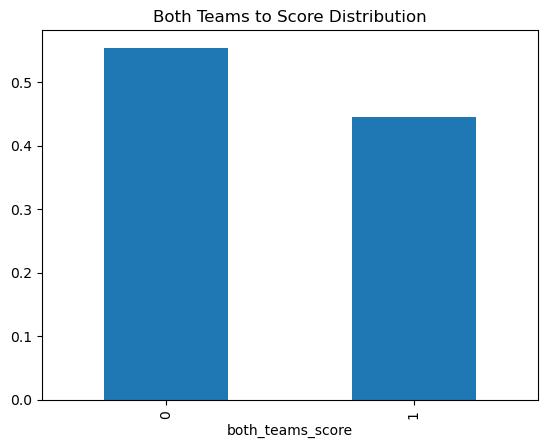

In [215]:
df_concat["both_teams_score"] = (df_concat["score.fullTime.home"] > 0) & (df_concat["score.fullTime.away"] > 0)
df_concat["both_teams_score"] = df_concat["both_teams_score"].astype(int)  # Convert to 0/1
# Distribution
print(df_concat["both_teams_score"].value_counts())
df_concat["both_teams_score"].value_counts(normalize=True).plot(kind="bar", title="Both Teams to Score Distribution")

In [217]:
# Aggregate stats by team
team_stats = df_concat.groupby("homeTeam.name").agg(
    home_goals=("score.fullTime.home", "mean"),
    away_goals=("score.fullTime.away", "mean"),
    both_teams_score=("both_teams_score", "mean")
).reset_index()

# Sort by both-teams-to-score probability
team_stats = team_stats.sort_values(by="both_teams_score", ascending=False)
print(team_stats.head())
# Consistent conversion to datetime (assuming UTC timezone)
df_concat['utcDate'] = pd.to_datetime(df_concat['utcDate'], utc=True)

    homeTeam.name  home_goals  away_goals  both_teams_score
13        Levante    1.447368    1.578947          0.605263
23     UD Almería    1.342105    1.526316          0.605263
26  Villarreal CF    1.891566    1.265060          0.589474
11     Granada CF    1.245614    1.508772          0.578947
7        Elche CF    1.052632    1.280702          0.543860


In [219]:
def calculate_recent_performance(df, n=5):
    # Initialize new columns
    df["home_recent_goals_scored"] = np.nan
    df["home_recent_goals_conceded"] = np.nan
    df["home_recent_both_teams_score"] = np.nan
    df["away_recent_goals_scored"] = np.nan
    df["away_recent_goals_conceded"] = np.nan
    df["away_recent_both_teams_score"] = np.nan

    # Iterate over unique teams
    for team in pd.concat([df["homeTeam.name"], df["awayTeam.name"]]).unique():
        team_matches = df[(df["homeTeam.name"] == team) | (df["awayTeam.name"] == team)]
        team_matches = team_matches.sort_values(by="utcDate")

        # Separate lists for home and away matches
        home_goals_scored = []
        home_goals_conceded = []
        home_both_teams_score = []

        away_goals_scored = []
        away_goals_conceded = []
        away_both_teams_score = []

        for idx, match in team_matches.iterrows():
            # Calculate rolling averages **excluding the current match**
            if match["homeTeam.name"] == team:  # Home match
                df.loc[idx, "home_recent_goals_scored"] = (
                    np.mean(home_goals_scored[-n:]) if home_goals_scored else np.nan
                )
                df.loc[idx, "home_recent_goals_conceded"] = (
                    np.mean(home_goals_conceded[-n:]) if home_goals_conceded else np.nan
                )
                df.loc[idx, "home_recent_both_teams_score"] = (
                    np.mean(home_both_teams_score[-n:]) if home_both_teams_score else np.nan
                )

                # Append current match results after calculation
                home_goals_scored.append(match["score.fullTime.home"])
                home_goals_conceded.append(match["score.fullTime.away"])
                home_both_teams_score.append((match["score.fullTime.home"] > 0) and (match["score.fullTime.away"] > 0))

            elif match["awayTeam.name"] == team:  # Away match
                df.loc[idx, "away_recent_goals_scored"] = (
                    np.mean(away_goals_scored[-n:]) if away_goals_scored else np.nan
                )
                df.loc[idx, "away_recent_goals_conceded"] = (
                    np.mean(away_goals_conceded[-n:]) if away_goals_conceded else np.nan
                )
                df.loc[idx, "away_recent_both_teams_score"] = (
                    np.mean(away_both_teams_score[-n:]) if away_both_teams_score else np.nan
                )

                # Append current match results after calculation
                away_goals_scored.append(match["score.fullTime.away"])
                away_goals_conceded.append(match["score.fullTime.home"])
                away_both_teams_score.append((match["score.fullTime.away"] > 0) and (match["score.fullTime.home"] > 0))

    return df



df_concat = calculate_recent_performance(df_concat, n=5)

In [221]:
# Rename columns for clarity
df_concat.rename(columns={
    "recent_goals_scored": "home_recent_goals_scored",
    "recent_goals_conceded": "home_recent_goals_conceded",
    "recent_both_teams_score": "home_recent_both_teams_score"
}, inplace=True)

df_concat.rename(columns={
    "recent_goals_scored": "away_recent_goals_scored",
    "recent_goals_conceded": "away_recent_goals_conceded",
    "recent_both_teams_score": "away_recent_both_teams_score"
}, inplace=True)

print(df_concat.head())

                    utcDate    status       homeTeam.name  \
0 2020-09-12 15:00:00+00:00  FINISHED               Eibar   
1 2020-09-12 17:30:00+00:00  FINISHED          Granada CF   
2 2020-09-12 20:00:00+00:00  FINISHED            Cádiz CF   
3 2020-09-13 13:00:00+00:00  FINISHED    Deportivo Alavés   
4 2020-09-13 15:00:00+00:00  FINISHED  Real Valladolid CF   

             awayTeam.name  matchday  season.id  score.fullTime.home  \
0         RC Celta de Vigo         0       1000                  0.0   
1            Athletic Club         0       1000                  2.0   
2               CA Osasuna         0       1000                  0.0   
3      Real Betis Balompié         0       1000                  0.0   
4  Real Sociedad de Fútbol         0       1000                  1.0   

   score.fullTime.away  both_teams_score  home_recent_goals_scored  \
0                  0.0                 0                       NaN   
1                  0.0                 0                    

In [223]:
def calculate_recent_btts_between_teams(df, n=5):
    # Initialize the new column
    df["recent_btts_between_teams"] = np.nan

    # Iterate through each match
    for idx, match in df.iterrows():
        home_team = match["homeTeam.name"]
        away_team = match["awayTeam.name"]

        # Filter matches involving the same two teams (either home-away or away-home)
        head_to_head_matches = df[
            ((df["homeTeam.name"] == home_team) & (df["awayTeam.name"] == away_team)) |
            ((df["homeTeam.name"] == away_team) & (df["awayTeam.name"] == home_team))
        ]

        # Sort by date to ensure chronological order
        head_to_head_matches = head_to_head_matches.sort_values(by="utcDate")

        # Exclude the current match
        past_matches = head_to_head_matches[head_to_head_matches["utcDate"] < match["utcDate"]]

        # Calculate the BTTS metric for the last `n` matches
        if len(past_matches) > 0:
            recent_btts = past_matches.tail(n).apply(
                lambda x: (x["score.fullTime.home"] > 0) and (x["score.fullTime.away"] > 0),
                axis=1
            )
            df.loc[idx, "recent_btts_between_teams"] = recent_btts.mean()  # Proportion of BTTS in recent matches
        else:
            df.loc[idx, "recent_btts_between_teams"] = np.nan  # No past matches available

    return df

df_concat = calculate_recent_btts_between_teams(df_concat, n=5)

In [224]:
def calculate_recent_btts_league(df, n=5):
    # Initialize the new column
    df["recent_btts_league"] = np.nan

    # Sort matches by date
    df = df.sort_values(by="utcDate")

    # Iterate over each match
    for idx, match in df.iterrows():
        # Filter for matches played before the current match
        past_matches = df[df["utcDate"] < match["utcDate"]]

        # Calculate the BTTS rate for the last `n` matches
        if len(past_matches) > 0:
            recent_btts = past_matches.tail(n).apply(
                lambda x: (x["score.fullTime.home"] > 0) and (x["score.fullTime.away"] > 0),
                axis=1
            )
            df.loc[idx, "recent_btts_league"] = recent_btts.mean()  # Proportion of BTTS in recent matches
        else:
            df.loc[idx, "recent_btts_league"] = np.nan  # No past matches available

    return df

df_concat = calculate_recent_btts_league(df_concat, n=5)

In [226]:
# Select relevant columns
selected_df = df_concat.loc[:, ["homeTeam.name", "awayTeam.name", "status", "matchday", "both_teams_score", "home_recent_both_teams_score",
                         "away_recent_both_teams_score", "recent_btts_between_teams", "recent_btts_league"]]

print(selected_df.head())

        homeTeam.name            awayTeam.name    status  matchday  \
0               Eibar         RC Celta de Vigo  FINISHED         0   
1          Granada CF            Athletic Club  FINISHED         0   
2            Cádiz CF               CA Osasuna  FINISHED         0   
3    Deportivo Alavés      Real Betis Balompié  FINISHED         0   
4  Real Valladolid CF  Real Sociedad de Fútbol  FINISHED         0   

   both_teams_score  home_recent_both_teams_score  \
0                 0                           NaN   
1                 0                           NaN   
2                 0                           NaN   
3                 0                           NaN   
4                 1                           NaN   

   away_recent_both_teams_score  recent_btts_between_teams  recent_btts_league  
0                           NaN                        NaN                 NaN  
1                           NaN                        NaN                 0.0  
2                

In [229]:
selected_df.to_csv("la_liga_with_recent_performance.csv", index=False)

In [231]:
df = pd.read_csv('la_liga_with_recent_performance.csv')

# Take game that we want to predict
filtered_game = df[ (df["homeTeam.name"] == 'Getafe CF') & (df["awayTeam.name"] == 'RCD Espanyol de Barcelona') & (df["matchday"] == 16) ]

# Fill out recent btts between teams with 0.5
df['recent_btts_between_teams'] = df['recent_btts_between_teams'].fillna(0.5)

# Filter for finished games
df = df[df['status'] == 'FINISHED']

# Remove matchday and status columns
df = df.loc[:, ["homeTeam.name", "awayTeam.name", "both_teams_score", "home_recent_both_teams_score",
                         "recent_btts_between_teams", "away_recent_both_teams_score", "recent_btts_league"]]

# Display the first 5 rows
print(df.head())

print("Number of observations before dropping NAs:", df.shape[0])

# Drop rows with missing values
df = df.dropna()

# Print the number of observations after dropping NAs
print("Number of observations after dropping NAs:", df.shape[0])

# Display the first 5 rows
print(df.head())

        homeTeam.name            awayTeam.name  both_teams_score  \
0               Eibar         RC Celta de Vigo                 0   
1          Granada CF            Athletic Club                 0   
2            Cádiz CF               CA Osasuna                 0   
3    Deportivo Alavés      Real Betis Balompié                 0   
4  Real Valladolid CF  Real Sociedad de Fútbol                 1   

   home_recent_both_teams_score  recent_btts_between_teams  \
0                           NaN                        0.5   
1                           NaN                        0.5   
2                           NaN                        0.5   
3                           NaN                        0.5   
4                           NaN                        0.5   

   away_recent_both_teams_score  recent_btts_league  
0                           NaN                 NaN  
1                           NaN                 0.0  
2                           NaN                 0.0  
3 

In [233]:
# One-hot encoding for team names
df = pd.get_dummies(df, columns=["homeTeam.name", "awayTeam.name"], drop_first=True)

X = df.drop(columns=["both_teams_score"])
y = df["both_teams_score"]

In [235]:
# Standardize numerical features
scaler = StandardScaler()
numerical_columns = [
    "home_recent_both_teams_score",
    "away_recent_both_teams_score",
    "recent_btts_league"
]
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(accuracy)

0.5396341463414634


In [237]:
# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[83 76]
 [75 94]]


In [239]:
# Access model coefficients
coefficients = model.coef_[0]  # Coefficients for logistic regression
features = X_train.columns

# Create a DataFrame for easy interpretation
importance_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(importance_df)

                                    Feature  Coefficient
44  awayTeam.name_RCD Espanyol de Barcelona     0.936801
29              homeTeam.name_Villarreal CF     0.934488
18  homeTeam.name_RCD Espanyol de Barcelona     0.920902
31                 awayTeam.name_CD Leganés     0.702623
13                  homeTeam.name_Girona FC     0.656111
14                 homeTeam.name_Granada CF     0.602542
26                 homeTeam.name_UD Almería     0.580313
52                 awayTeam.name_UD Almería     0.546477
16                    homeTeam.name_Levante     0.520496
28                homeTeam.name_Valencia CF     0.455258
35                      awayTeam.name_Eibar     0.424794
17           homeTeam.name_RC Celta de Vigo     0.416336
39                  awayTeam.name_Girona FC     0.397376
20   homeTeam.name_Rayo Vallecano de Madrid     0.326260
10                   homeTeam.name_Elche CF     0.307269
40                 awayTeam.name_Granada CF     0.301992
55              awayTeam.name_V

In [241]:
baseline_accuracy = y_test.value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.52


In [243]:
# Predict the following game
print(filtered_game)
# Remove matchday and status columns
filtered_game = filtered_game.loc[:, ["homeTeam.name", "awayTeam.name", "both_teams_score", "home_recent_both_teams_score",
                         "recent_btts_between_teams", "away_recent_both_teams_score", "recent_btts_league"]]

# One-hot encoding for team names in the filtered game
filtered_game_encoded = pd.get_dummies(filtered_game, columns=["homeTeam.name", "awayTeam.name"], drop_first=True)

# Align the filtered_game_encoded columns with the training data
filtered_game_encoded = filtered_game_encoded.reindex(columns=X.columns, fill_value=0)

# Standardize numerical features using the previously fitted scaler
numerical_columns = [
    "home_recent_both_teams_score",
    "away_recent_both_teams_score",
    "recent_btts_league"
]

filtered_game_encoded[numerical_columns] = scaler.transform(filtered_game_encoded[numerical_columns])

# Predict the outcome using the logistic regression model
prediction = model.predict(filtered_game_encoded)
prediction_proba = model.predict_proba(filtered_game_encoded)

# Display the prediction
print(f"Predicted Both Teams to Score (BTTS): {bool(prediction[0])}")
print(f"Prediction Probability: {prediction_proba[0]}")

     homeTeam.name              awayTeam.name status  matchday  \
1679     Getafe CF  RCD Espanyol de Barcelona  TIMED        16   

      both_teams_score  home_recent_both_teams_score  \
1679                 0                           0.4   

      away_recent_both_teams_score  recent_btts_between_teams  \
1679                           0.8                        0.5   

      recent_btts_league  
1679                 0.4  
Predicted Both Teams to Score (BTTS): False
Prediction Probability: [0.53829694 0.46170306]


In [245]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Evaluate the model
dt_accuracy = dt_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

Decision Tree Accuracy: 0.50


In [247]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.51


In [255]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"k-NN Accuracy: {knn_accuracy:.2f}")

k-NN Accuracy: 0.52


In [257]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.52
